# Gaussian Process Model

#### Training Data
Consider a set of training data consisting of input-output pairs $(X_{\text{train}}, Y_{\text{train}})$, where 
- $X_{\text{train}} = \{x_1, x_2, \ldots, x_n\}$ is a set of $n$ input points.
- $Y_{\text{train}} = \{y_1, y_2, \ldots, y_n\}$ is the corresponding set of $n$ output values.

#### Radial Basis Function (RBF) Kernel
The RBF kernel (also known as the squared exponential kernel) between two points $x$ and $x'$ is defined as:
$$ k(x, x') = \sigma^2 \exp\left(-\frac{||x - x'||^2}{2l^2}\right) $$
where 
- $\sigma^2$ is the variance parameter, controlling the vertical variation.
- $l$ is the length scale parameter, controlling the horizontal variation (the smoothness).

#### Covariance Matrix
The covariance matrix $K$ for the training data $X_{\text{train}}$ is formed by applying the RBF kernel to all pairs of training inputs:
$$ K = \begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) & \cdots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) & \cdots & k(x_2, x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n, x_1) & k(x_n, x_2) & \cdots & k(x_n, x_n)
\end{bmatrix} $$

#### Posterior Mean and Variance
Given a set of test inputs $X_{\text{test}} = \{x^*_1, x^*_2, \ldots, x^*_m\}$, the Gaussian Process model predicts the posterior mean and variance for each test input. The posterior mean $\mu^*$ and covariance $K^*$ at the test points are given by:
$$ \mu^* = K^*(X_{\text{train}}, X_{\text{test}}) \cdot K^{-1}(X_{\text{train}}, X_{\text{train}}) \cdot Y_{\text{train}} $$
$$ K^* = K(X_{\text{test}}, X_{\text{test}}) - K^*(X_{\text{train}}, X_{\text{test}}) \cdot K^{-1}(X_{\text{train}}, X_{\text{train}}) \cdot K^*(X_{\text{test}}, X_{\text{train}}) $$
where 
- $K^*(X_{\text{train}}, X_{\text{test}})$ is the covariance matrix between the training inputs and test inputs.
- $K(X_{\text{test}}, X_{\text{test}})$ is the covariance matrix between the test inputs.

#### Noise Model
In practice, a noise term $\sigma_n^2 I$ is often added to the diagonal of $K$ to account for observation noise, where $I$ is the identity matrix and $\sigma_n^2$ is the variance of the noise.

#### Negative Log Marginal Likelihood
The Negative Log Marginal Likelihood (NLML) is used for training the hyperparameters of the Gaussian Process. It is given by:
$$ \text{NLML} = \frac{1}{2} Y_{\text{train}}^T K^{-1} Y_{\text{train}} + \frac{1}{2} \log |K| + \frac{n}{2} \log(2\pi) $$


Epoch 1/2000, Loss: 2665.68896484375, NLML: 11.162282943725586, MSE: 0.26545265316963196
Epoch 101/2000, Loss: 2533.657958984375, NLML: 10.792224884033203, MSE: 0.2522865831851959
Epoch 201/2000, Loss: 2117.12255859375, NLML: 11.567255973815918, MSE: 0.2105555385351181
Epoch 301/2000, Loss: 1558.8748779296875, NLML: 14.051641464233398, MSE: 0.15448231995105743
Epoch 401/2000, Loss: 1101.8026123046875, NLML: 17.415855407714844, MSE: 0.10843867063522339
Epoch 501/2000, Loss: 872.0233764648438, NLML: 20.079641342163086, MSE: 0.08519437164068222
Epoch 601/2000, Loss: 785.7360229492188, NLML: 21.55022621154785, MSE: 0.07641857862472534
Epoch 701/2000, Loss: 753.9683837890625, NLML: 22.21319580078125, MSE: 0.07317551970481873
Epoch 801/2000, Loss: 738.5147705078125, NLML: 22.39655113220215, MSE: 0.07161182165145874
Epoch 901/2000, Loss: 726.4119262695312, NLML: 22.31067657470703, MSE: 0.07041012495756149
Epoch 1001/2000, Loss: 713.9049072265625, NLML: 22.087345123291016, MSE: 0.0691817551851

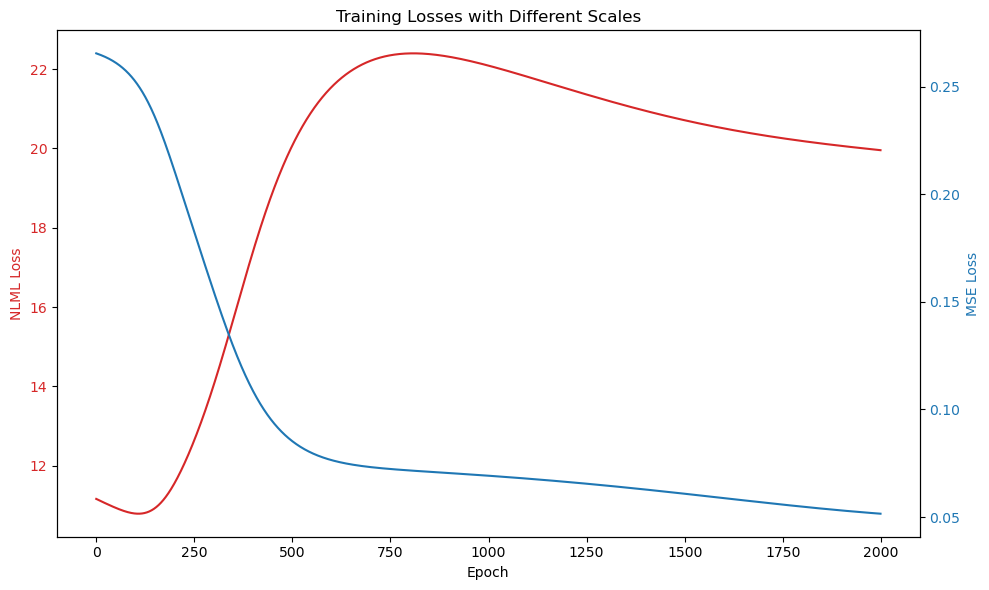

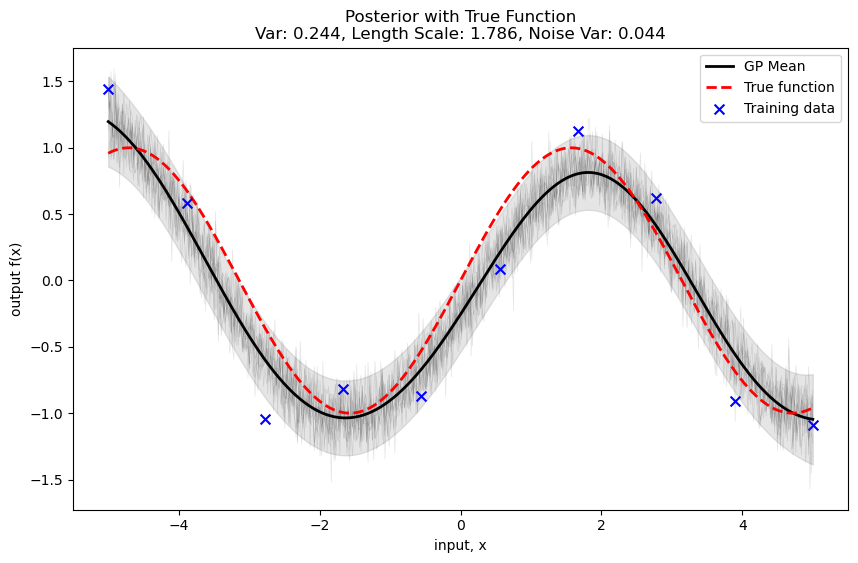

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam


class GaussianProcess(nn.Module):
    def __init__(self, var=1.0, length_scale=1.0, noise_var=0.01):
        super(GaussianProcess, self).__init__()
        self.log_var = nn.Parameter(torch.log(torch.tensor([var], dtype=torch.float32)))
        self.log_length_scale = nn.Parameter(torch.log(torch.tensor([length_scale], dtype=torch.float32)))
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor([noise_var], dtype=torch.float32)))
        self.X_train = None
        self.y_train = None

    def rbf_kernel(self, X1, X2):
        # Validate input shapes
        assert X1.shape[1] == X2.shape[1], "X1 and X2 must have the same number of features"
        sqdist = torch.sum(X1 ** 2, 1).reshape(-1, 1) + torch.sum(X2 ** 2, 1) - 2 * torch.matmul(X1, X2.t())
        return torch.exp(self.log_var) * torch.exp(-0.5 / torch.exp(self.log_length_scale) ** 2 * sqdist)

    def nlml(self, X, y):
        # Validate input shapes
        assert X.ndim == 2 and y.ndim == 2, "X and y must be 2D tensors"
        assert X.size(0) == y.size(0), "Number of samples in X and y must match"
        K = self.rbf_kernel(X, X) + torch.exp(self.log_noise_var) * torch.eye(X.size(0))
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(K.size(0)))
        inv_y = torch.cholesky_solve(y, L)
        logdet = 2 * torch.sum(torch.log(torch.diag(L)))
        return 0.5 * y.t().mm(inv_y) + 0.5 * logdet + 0.5 * X.size(0) * torch.log(torch.tensor(2 * np.pi))

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        # Use the stored training data to make predictions on the test data
        return self._predict(self.X_train, self.y_train, X_test)

    def _predict(self, X_train, y_train, X_test):
        # Calculate kernel matrices
        K = self.rbf_kernel(X_train, X_train) + torch.exp(self.log_noise_var) * torch.eye(X_train.size(0))
        K_s = self.rbf_kernel(X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test) + 1e-8 * torch.eye(X_test.size(0))  # Add jitter for stability
        
        # Cholesky decomposition
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(K.size(0)))
        
        # Compute the mean at our test points
        Lk = torch.linalg.solve(L, K_s)
        mu = torch.matmul(Lk.t(), torch.linalg.solve(L, y_train)).squeeze(-1)
        
        # Compute the variance at our test points
        variance = torch.diag(K_ss) - torch.sum(Lk ** 2, axis=0)
        return mu, variance

    def compute_gradient(self, X):
        """
        Compute the gradient of the GP's predictive mean with respect to the inputs X.

        Parameters:
        X (torch.Tensor): Input tensor for which gradients are to be computed. Must require grad.

        Returns:
        torch.Tensor: Gradients of the predictive mean w.r.t. the input X.
        """
        # Ensure that X requires gradient
        X.requires_grad_(True)

        # Predict the mean at the input points
        # Keep track of the computation graph for this operation to compute gradients later
        mean, _ = self.predict(X)

        # Compute the gradient of the mean w.r.t. X
        gradients = torch.autograd.grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), create_graph=True)[0]

        # Returning the gradient with respect to the input X
        return gradients.squeeze()
    
    def plot_posterior(self, X_test, true_func, num_samples=10, confidence_interval=0.95):
        # Ensure model is in evaluation mode
        self.eval()
        
        # Predict the mean and variance for each point in X_test
        with torch.no_grad():
            mean, var = self.predict(X_test)
            std_dev = torch.sqrt(var)
        # Correctly repeat and expand dimensions for sampling
        mean = mean.repeat(num_samples, 1).t()  # Transpose to match dimensions
        std_dev = std_dev.repeat(num_samples, 1).t()  # Transpose to match dimensions
        
        # Generate samples from the posterior distribution
        samples = torch.normal(mean, std_dev)
        
        # Calculate the z-score for the desired confidence interval
        z_score = torch.distributions.Normal(0, 1).icdf(torch.tensor((1 - confidence_interval) / 2 + confidence_interval))
        
        # Plotting
        fig = plt.figure(figsize=(10, 6))
        for i in range(num_samples):
            plt.plot(X_test.numpy(), samples[:, i].numpy(), 'k-', linewidth=0.5, alpha=0.1)
        plt.plot(X_test.numpy(), mean[:,0].numpy(), 'k-', linewidth=2, label='GP Mean')  # Use the first row of samples as the mean
        plt.fill_between(X_test.flatten().numpy(), (mean[:,0] - z_score * std_dev[:,0]).numpy(), (mean[:,0] + z_score * std_dev[:,0]).numpy(), color='gray', alpha=0.2)
        
        # Plot the true function
        true_y = true_func(X_test)
        plt.plot(X_test.numpy(), true_y.numpy(), 'r--', linewidth=2, label='True function')
        
        # Plot the training data
        plt.scatter(self.X_train.numpy(), self.y_train.numpy(), c='blue', s=50, marker='x', zorder=5, label='Training data')
        
        plt.xlabel('input, x')
        plt.ylabel('output f(x)')
        plt.title('Posterior with True Function\nVar: {:.3f}, Length Scale: {:.3f}, Noise Var: {:.3f}'.format(torch.exp(self.log_var).item(), torch.exp(self.log_length_scale).item(), torch.exp(self.log_noise_var).item()))
        plt.legend()
        plt.show()



# The true function
def true_func(x, div=False):
    if div:
        return torch.cos(x)
    else:
        return torch.sin(x)

# Set the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Generate training data
N = 10
xmin, xmax = -5, 5
noise_var = 0.1
x_train = torch.linspace(xmin, xmax, N).unsqueeze(-1)
x_test = torch.linspace(xmin, xmax, 500).unsqueeze(-1)
x_colocation = torch.linspace(xmin, xmax, 100).unsqueeze(-1)
y_train = true_func(x_train) + torch.randn(N, 1) * torch.sqrt(torch.tensor(noise_var))

# Instantiate the model
gp_model = GaussianProcess()

# Fit the model with training data
gp_model.fit(x_train, y_train)

# Training settings
learning_rate = 0.001
alpha = 10000
epochs = 2000
optimizer = Adam(gp_model.parameters(), lr=learning_rate)

# Initialize lists to store loss values
total_loss_values = []
nlml_loss_values = []
mse_loss_values = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero gradients

    # Compute NLML loss
    nlml_loss = gp_model.nlml(x_train, y_train)

    # Compute gradient and residual loss
    predicted_mean_grad = gp_model.compute_gradient(x_colocation)
    true_grad = true_func(x_colocation, div=True)
    residual = predicted_mean_grad.reshape(-1,1) - true_grad

    # MSE loss for the residual
    mse_loss = torch.mean(residual ** 2)

    # Total loss
    loss = nlml_loss + alpha*mse_loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters

    # Store losses for plotting
    total_loss_values.append(loss.item())
    nlml_loss_values.append(nlml_loss.item())
    mse_loss_values.append(mse_loss.item())

    # Print progress
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, NLML: {nlml_loss.item()}, MSE: {mse_loss.item()}')

# Plot the losses
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot NLML loss and MSE loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('NLML Loss', color=color)
ax1.plot(nlml_loss_values, color=color, label='NLML Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('MSE Loss', color=color)
ax2.plot(mse_loss_values, color=color, label='MSE Loss')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and show plot
plt.title('Training Losses with Different Scales')
fig.tight_layout()
plt.show()


# After training, call plot_posterior
gp_model.plot_posterior(x_test, true_func)


### Enforcing Derivative Matching in Gaussian Process

#### Overview
In addition to minimizing the Negative Log Marginal Likelihood (NLML), the training of the Gaussian Process (GP) model can be augmented by enforcing that the derivative of the GP's posterior mean matches the derivative of the true solution. This approach can be particularly beneficial in problems where the derivatives of the function are as important as the function values themselves, such as in differential equations or gradient-based optimization tasks.

#### Derivative Matching
Let $ X_{\text{colocation}} = \{x^c_1, x^c_2, \ldots, x^c_m\} $ be a set of colocation points where the derivatives are evaluated. The objective is to match the derivatives of the GP's posterior mean at these points with the derivatives of the true solution.

If $ f(x) $ represents the true solution, then its derivative at a colocation point $ x^c $ is given by $ f'(x^c) $. Similarly, the derivative of the GP's posterior mean at $ x^c $ is denoted as $ \mu'(x^c) $.

#### Residual Loss
The residual loss is computed as the mean squared error (MSE) between the predicted derivatives and the true derivatives:
$$ \text{MSE Loss} = \frac{1}{m} \sum_{i=1}^{m} \left( \mu'(x^c_i) - f'(x^c_i) \right)^2 $$

#### Total Loss Function
The total loss function is a weighted sum of the NLML and the MSE loss of the derivatives:
$$ \text{Total Loss} = \text{NLML} + \alpha \cdot \text{MSE Loss} $$
where:
- $\alpha$ is a weighting factor that balances the importance of the NLML and the MSE loss.

#### Training Objective
During training, both the NLML and the MSE loss are minimized simultaneously. This leads to a GP model that not only fits the training data well (as measured by NLML) but also aligns its predictive derivatives with those of the true function (as measured by the MSE loss of derivatives).

#### Implementation in Training Loop
In the training loop, the `compute_gradient` method of the GP model is used to compute $ \mu'(X_{\text{colocation}}) $, and the true derivatives $ f'(X_{\text{colocation}}) $ are obtained using a predefined function. The total loss is then computed as the sum of the NLML and the weighted MSE loss of derivatives, which is used for backpropagation and optimization.


GP model without derivative loss


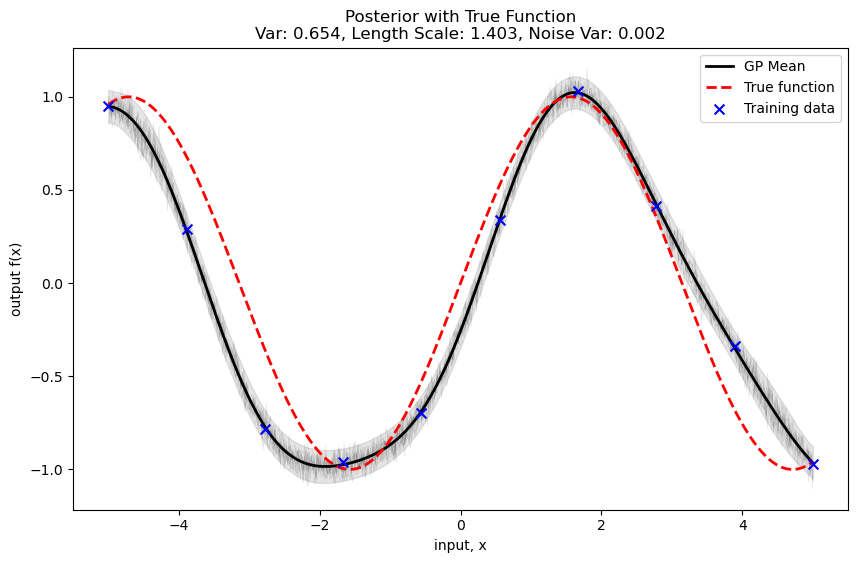

GP model with derivative loss


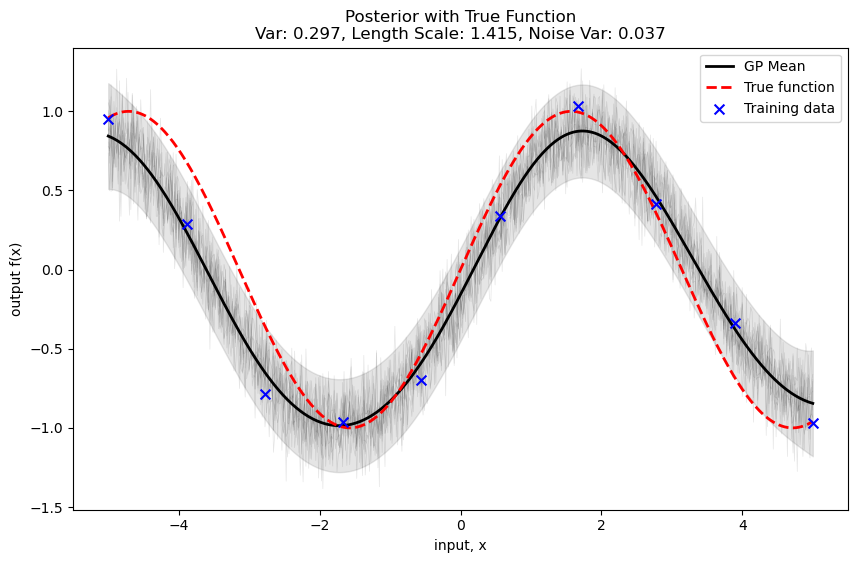

In [6]:
def train_gp(gp_model, x_train, y_train, x_colocation, include_derivative_loss, alpha=10000, learning_rate=0.001, epochs=2000):
    optimizer = Adam(gp_model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero gradients

        # Compute NLML loss
        nlml_loss = gp_model.nlml(x_train, y_train)

        if include_derivative_loss:
            # Compute gradient and residual loss
            predicted_mean_grad = gp_model.compute_gradient(x_colocation)
            true_grad = true_func(x_colocation, div=True)
            residual = predicted_mean_grad.reshape(-1,1) - true_grad

            # MSE loss for the residual
            mse_loss = torch.mean(residual ** 2)

            # Total loss
            loss = nlml_loss + alpha * mse_loss
        else:
            loss = nlml_loss

        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

# Define the true function and its derivative
def true_func(x, div=False):
    # Replace this with the actual function and its derivative
    y = torch.sin(x)
    if div:
        y = torch.cos(x)
    return y

# Generate training data
N = 10
xmin, xmax = -5, 5
noise_var = 0.1
x_train = torch.linspace(xmin, xmax, N).unsqueeze(-1)
x_test = torch.linspace(xmin, xmax, 500).unsqueeze(-1)
x_colocation = torch.linspace(xmin, xmax, 100).unsqueeze(-1)
y_train = true_func(x_train) + torch.randn(N, 1) * torch.sqrt(torch.tensor(noise_var))

# Instantiate and train the first GP model (without derivative loss)
gp_model_no_derivative = GaussianProcess()
gp_model_no_derivative.fit(x_train, y_train)
train_gp(gp_model_no_derivative, x_train, y_train, x_colocation, include_derivative_loss=False)

# Instantiate and train the second GP model (with derivative loss)
gp_model_with_derivative = GaussianProcess()
gp_model_with_derivative.fit(x_train, y_train)
train_gp(gp_model_with_derivative, x_train, y_train, x_colocation, include_derivative_loss=True)

# Plot for GP model without derivative loss
print('GP model without derivative loss')
gp_model_no_derivative.plot_posterior(x_test, true_func)

# Plot for GP model with derivative loss
print('GP model with derivative loss')
gp_model_with_derivative.plot_posterior(x_test, true_func)


GP model without derivative loss


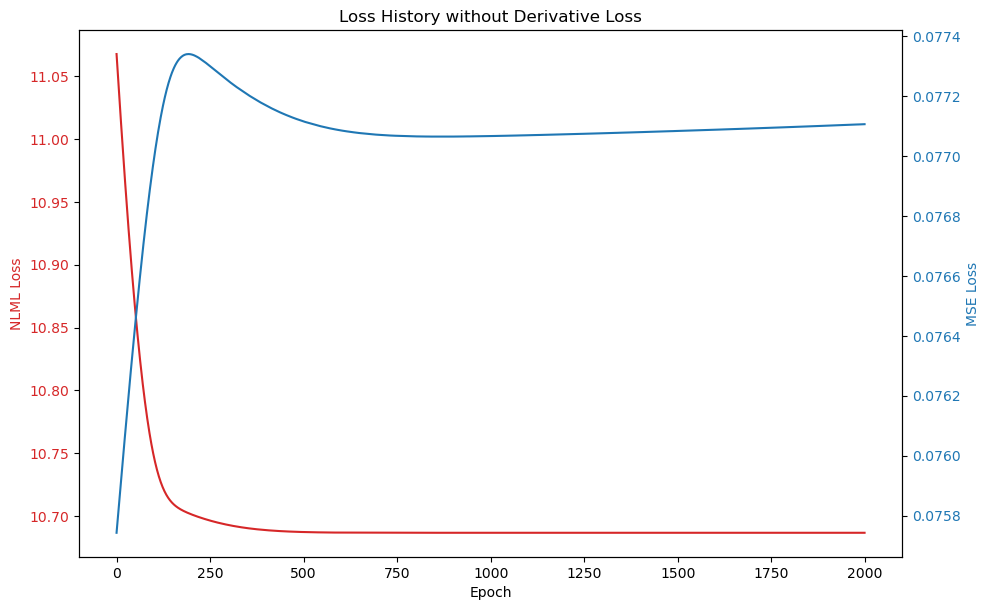

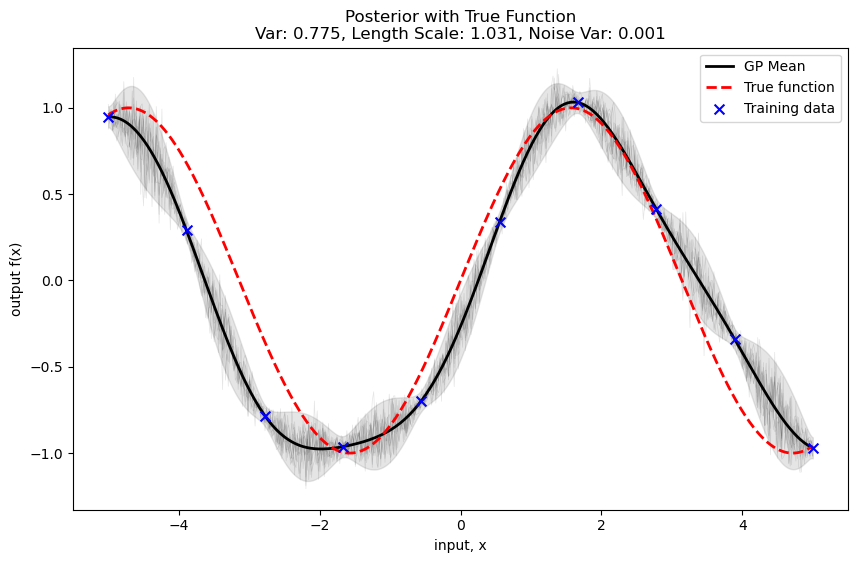

GP model with derivative loss


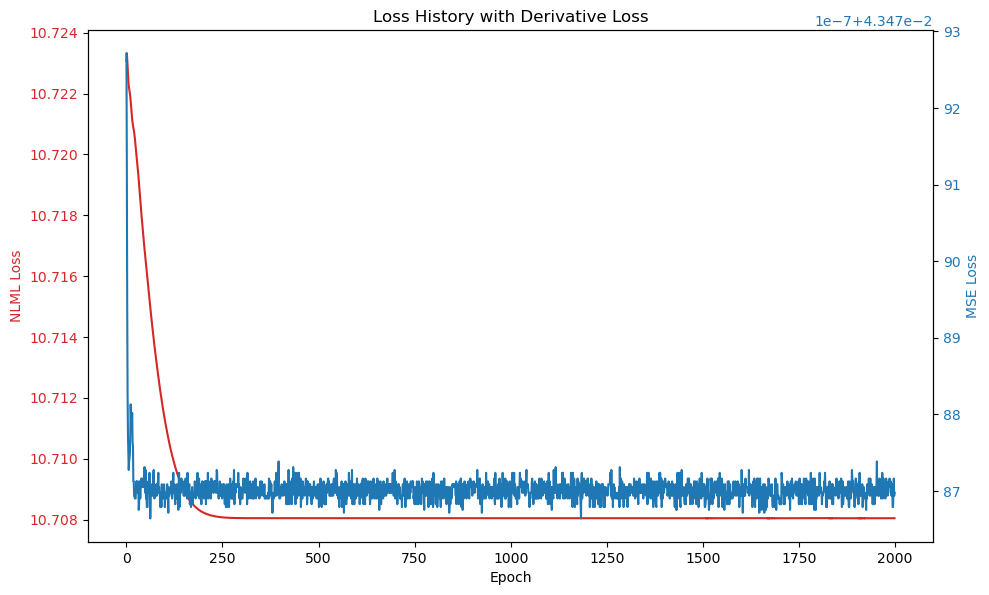

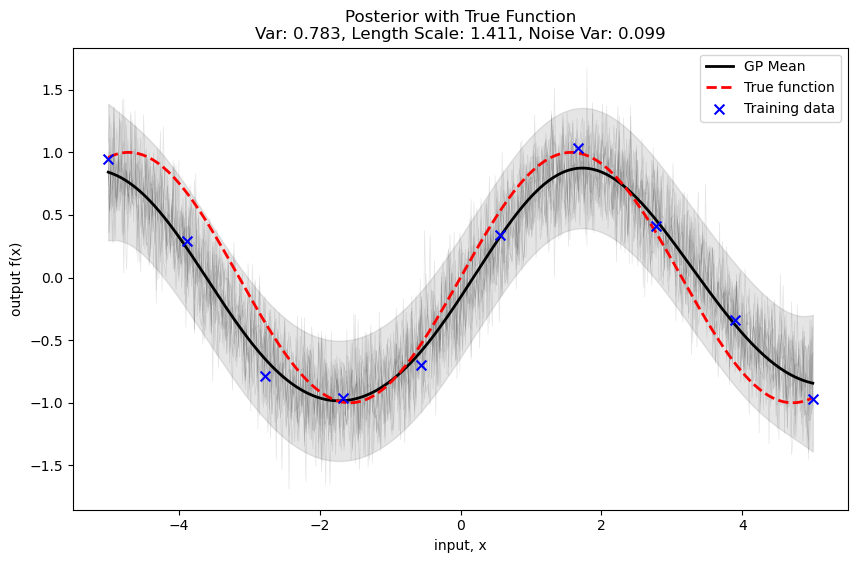

In [12]:
def train_gp(gp_model, x_train, y_train, x_colocation, include_derivative_loss, alpha=10000, learning_rate=0.001, epochs=2000):
    optimizer = Adam(gp_model.parameters(), lr=learning_rate)
    
    # Initialize lists to store loss values
    loss_history = {'total_loss': [], 'nlml_loss': [], 'mse_loss': []}

    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero gradients

        # Compute NLML loss
        nlml_loss = gp_model.nlml(x_train, y_train)

        # Compute gradient and residual loss regardless of whether it is included in the total loss
        predicted_mean_grad = gp_model.compute_gradient(x_colocation)
        true_grad = true_func(x_colocation, div=True)
        residual = predicted_mean_grad.reshape(-1,1) - true_grad
        mse_loss = torch.mean(residual ** 2)

        # Determine total loss based on whether derivative loss is included
        loss = nlml_loss + alpha * mse_loss if include_derivative_loss else nlml_loss

        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        # Store losses for plotting
        loss_history['total_loss'].append(loss.item())
        loss_history['nlml_loss'].append(nlml_loss.item())
        loss_history['mse_loss'].append(mse_loss.item())

    return loss_history

# Define the true function and its derivative
def true_func(x, div=False):
    # Replace this with the actual function and its derivative
    y = torch.sin(x)
    if div:
        y = torch.cos(x)
    return y

# Generate training data
N = 10
xmin, xmax = -5, 5
noise_var = 0.1
x_train = torch.linspace(xmin, xmax, N).unsqueeze(-1)
x_test = torch.linspace(xmin, xmax, 500).unsqueeze(-1)
x_colocation = torch.linspace(xmin, xmax, 100).unsqueeze(-1)
y_train = true_func(x_train) + torch.randn(N, 1) * torch.sqrt(torch.tensor(noise_var))

# Train and get loss history for both models
loss_history_no_derivative = train_gp(gp_model_no_derivative, x_train, y_train, x_colocation, include_derivative_loss=False)
loss_history_with_derivative = train_gp(gp_model_with_derivative, x_train, y_train, x_colocation, include_derivative_loss=True)

# Plot the losses for both models
def plot_loss_history(loss_history, title):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('NLML Loss', color=color)
    ax1.plot(loss_history['nlml_loss'], color=color, label='NLML Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('MSE Loss', color=color)
    ax2.plot(loss_history['mse_loss'], color=color, label='MSE Loss')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # Adjust layout
    plt.title(title)
    plt.show()

# Plot for GP model without derivative loss
print('GP model without derivative loss')
plot_loss_history(loss_history_no_derivative, 'Loss History without Derivative Loss')
gp_model_no_derivative.plot_posterior(x_test, true_func)

# Plot for GP model with derivative loss
print('GP model with derivative loss')
plot_loss_history(loss_history_with_derivative, 'Loss History with Derivative Loss')
gp_model_with_derivative.plot_posterior(x_test, true_func)
